<a href="https://colab.research.google.com/github/BernardoRMendes/Projeto/blob/main/VaR_Modificado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
!pip install yahooquery
from yahooquery import Ticker
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 5.5MB 5.5MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp36-none-any.whl size=7013 sha256=c56afa76761a3c9b4229ad0aa71a7e296df41b1671da4833e307f44d3ea95d9c
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built requests-futures
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


Nesse estudo iremos mostrar que o VaR (Value at Risk), em sua versão paramétrica mais comum, não é uma medida adequada de risco e apresentaremos uma versão modificada, com aplicações na construção de portfólios.

O VaR calcula a perda máxima esperada para um portfólio em determinado intervalo de tempo, dado um nível de confiança. Como exemplo, podemos dizer que a perda máxima é de 100000 reais em um dia, com nível de confiança de 95%. Chegamos nesse valor multiplicando o Valor do Portfolio, o Z-Score (assumindo distribuição normal para os retornos) e o desvio padrão do portfólio.

No entanto, o VaR não diz nada sobre as piores perdas (acima de 95% de confiança), e também desconsidera outros momentos da distrubuição estatística, como o Skew e a Curtose. Skew é uma medida de assimetria, enquanto a Curtose é uma medida de achatamento, indicando a "gordura" das caudas. A Distribuição Normal tem Skew=0 e Curtose=3.

A Versão Modificada do VaR (ModifiedVar), também chamada de Cornish-Fisher VaR, calcula o VaR considerando o skew e a Curtose pela fórmula:

CFVaR= sigma*(z+(z^2-1)*s/6+(z^3-3z)*(k-3)/24-(2z^3-5z)*(s^2)/36), onde:

sigma = desvio padrão

z= Z-Score

s= Skew

k= Kurtosis


In [2]:
def skewness(r):
    """
    Calcula o skew (assimetria na distribuição) dos retornos

    """
    demeaned_r = r - r.mean()
    sigma_r = r.std()
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Calcula a Curtose da série de retornos
    """
    demeaned_r = r - r.mean()
    sigma_r = r.std()
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

                         
def annualize_rets(r, periods_per_year):
    """
    Retorno Anualizado
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Volatilidade dos retornos em formato anualizado
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Calcula o Sharpe anualizado
    """
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


def drawdown(return_series: pd.Series):
    """Recebe uma série de retornos e
       retorna um dataframe com o valor acumulado,
       picos prévios, e o drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def var_gaussian(r, level=5, modified=False):
    """
    Retorna o VaR Gaussiano Paramétrico de uma Série ou DataFrame
    Se "modified" for True, o VaR Modificado é retornado,
    usando a modificação Cornish-Fisher
    """
    # Calcula o Z Score assumindo distribuição Normal
    z = norm.ppf(level/100)
    if modified:
        # Modifica o Z Score com base no Skew e Curtose observados
        s = skewness(r)
        k = kurtosis(r)
        z = (z+(z**2-1)*s/6+(z**3-3*z)*(k-3)/24-(2*z**3-5*z)*(s**2)/36)
    return -z*r.std()

No exemplo abaixo, vamos verificar como o valor em risco altera de acordo com o skew e a Curtose:

In [3]:
skewlist=np.array([-0.5,0.5,-0.5,0.5,-0.5,0.5,-0.5,0.5])
level=np.array([0.1,0.1,1,1,2.5,2.5,5,5])
x=np.arange(len(level))
sigma=0.01
VaR=list()
for i in x:
  z=norm.ppf(level[x]/100)
  VaR.append(sigma*z)
  
data=pd.DataFrame(index=level,data=VaR[0])
data=pd.DataFrame(data=[level,skewlist])
data=data.T
data.columns=["Alfa","Skew"]
data["VaR"]=VaR[0]
k=3
s=data["Skew"]
z=norm.ppf(data["Alfa"]/100)
data["ModifiedVar"]=sigma*(z+(z**2-1)*s/6+(z**3-3*z)*(k-3)/24 -(2*z**3-5*z)*(s**2)/36)
data

,Alfa,Skew,VaR,ModifiedVar
0,0.1,-0.5,-0.030902,-0.035001
1,0.1,0.5,-0.030902,-0.020752
2,1.0,-0.5,-0.023263,-0.025999
3,1.0,0.5,-0.023263,-0.018646
4,2.5,-0.5,-0.019600,-0.021602
5,2.5,0.5,-0.019600,-0.016867
6,5.0,-0.5,-0.016449,-0.017823
7,5.0,0.5,-0.016449,-0.014980


Para um mesmo alfa, o verdadeiro Valor em Risco, em valores absolutos, é sempre maior se o Skew for negativo, e menor se for positivo. Ter assimetria de retornos positiva diminui o risco.

In [4]:
kurtlist=np.array([1,10,1,10,1,10,1,10])
level=np.array([0.1,0.1,1,1,2.5,2.5,5,5])
x=np.arange(len(level))
sigma=0.01
VaR=list()
for i in x:
  z=norm.ppf(level[x]/100)
  VaR.append(sigma*z)
  
data=pd.DataFrame(index=level,data=VaR[0])
data=pd.DataFrame(data=[level,kurtlist])
data=data.T
data.columns=["Alfa","Kurtosis"]
data["VaR"]=VaR[0]
s=0
k=data["Kurtosis"]
z=norm.ppf(data["Alfa"]/100)
data["ModifiedVar"]=sigma*(z+(z**2-1)*s/6+(z**3-3*z)*(k-3)/24 -(2*z**3-5*z)*(s**2)/36)
data

,Alfa,Kurtosis,VaR,ModifiedVar
0,0.1,1.0,-0.030902,-0.014036
1,0.1,10.0,-0.030902,-0.089934
2,1.0,1.0,-0.023263,-0.018588
3,1.0,10.0,-0.023263,-0.039629
4,2.5,1.0,-0.019600,-0.018225
5,2.5,10.0,-0.019600,-0.024410
6,5.0,1.0,-0.016449,-0.016852
7,5.0,10.0,-0.016449,-0.015036


Observe que o Valor em Risco considerando a Curtose somente se torna relevante nos extremos da distribuição. Para um alfa de 5%, o valor em risco é maior com  Curtose=1 do que com  Curtose=10. À primeira vista isso pode parecer estranho, mas já é um resultado esperado, pois distribuições com alta  Curtose possuem caudas gordas, mas o centro da distribuição possui um pico mais alto, concentrando a maior parte dos resultados. Com alfa=0,1%, vemos que o risco na distribuição com excesso de  Curtose é muito maior, indicando a presença de caudas gordas (-0,08934 contra -0,030902 e -0,014036).

Ir além das premissas de normalidade é fundamental na avaliação de riscos. Em um portfólio, podemos construir estratégias com assimetria negativa e alta curtose enquanto nosso VaR parece controlado. Quando se otimiza um portfólio analisando apenas a volatilidade, corre-se o risco de alterar negativamente outros momentos da distribuição de probabilidades dos retornos. Assim, podemos ter um portfólio com excelente Sharpe Ratio, mas cujo risco esteja escondido tanto na presença de assimetria negativa como de excesso de curtose. O que muitas vezes é reportado como "Outlier" ou "Cisno Negro" está totalmente dentro do esperado, quando outras medidas de risco são consideradas.

Para testar esse conceitos em prática, vamos construir um portfólio com o SPY e o VIX. O VIX, apesar de não ser diretamente investível, possui propriedades estatísticas interessantes, como excesso de curtose e assimetria positiva nos retornos.

*É possível investir no VIX por meio de contratos futuros, mas como sua estrutura a termo geralmente é do tipo contango, há um forte decaimento ao longo do tempo, então as performances apresentadas são irreais. O que podemos tirar de lição é se a análise de outros momentos estatísticos melhoram o desempenho do portfólio e, caso positivo, tentarmos replicar essas propriedades estatísticas por meio de outras estratégias.

Após coletar os dados do SPY e do VIX de 2010 a 2015, vamos montar dois portfólios e testá-los no período de 2016 a 2020.
O Portfólio 1 terá pesos inversamente proporcionais ao VaR, enquanto o Portfólio 2 terá pesos inversamente proporcionais ao ModifiedVar, ambos com 99% de confiança.

In [5]:
lista=["SPY","^VIX"]

In [6]:
portfolio=pd.DataFrame()
i=np.arange(len(lista))
for i in i:
  try:
    a=Ticker(lista[i])
    df=a.history(start="2010-01-01",end="2015-12-31",interval='1d')
    df=df['adjclose']
    df=df.pct_change()
    df=df.droplevel("symbol")
    portfolio[lista[i]]=df
  except:
    pass

In [7]:
portfolio.dropna(inplace=True)
portfolio.head()

,SPY,^VIX
date,,
2010-01-05,0.002647,-0.034431
2010-01-06,0.000704,-0.009819
2010-01-07,0.004222,-0.005219
2010-01-08,0.003327,-0.048793
2010-01-11,0.001397,-0.031991


In [8]:
spy=dict()
spy["Annualized Return"]=annualize_rets(portfolio["SPY"],252)*100
spy["Annualized Vol"]=annualize_vol(portfolio["SPY"],252)*100
spy["Skewness"]=skewness(portfolio["SPY"])
spy["Kurtosis"]=kurtosis(portfolio["SPY"])
spy["Sharpe Ratio"]=sharpe_ratio(portfolio["SPY"],0,252)
spy["Max Drawdown"]=drawdown(portfolio["SPY"]).Drawdown.min()*100
spy["Calmar Ratio"]=abs(spy["Annualized Return"]/spy["Max Drawdown"])
spy["VaR"]=var_gaussian(portfolio["SPY"],level=1)
spy["ModifiedVar"]=var_gaussian(portfolio["SPY"],level=1,modified=True)
spy=pd.DataFrame.from_dict(spy.items())
spy=spy.set_index(0)
spy.index.name=None
spy.columns=["SPY"]

VIX=dict()
VIX["Annualized Return"]=annualize_rets(portfolio["^VIX"],252)*100
VIX["Annualized Vol"]=annualize_vol(portfolio["^VIX"],252)*100
VIX["Skewness"]=skewness(portfolio["^VIX"])
VIX["Kurtosis"]=kurtosis(portfolio["^VIX"])
VIX["Sharpe Ratio"]=sharpe_ratio(portfolio["^VIX"],0,252)
VIX["Max Drawdown"]=drawdown(portfolio["^VIX"]).Drawdown.min()*100
VIX["Calmar Ratio"]=abs(VIX["Annualized Return"]/VIX["Max Drawdown"])
VIX["VaR"]=var_gaussian(portfolio["^VIX"],level=1)
VIX["ModifiedVar"]=var_gaussian(portfolio["^VIX"],level=1,modified=True)
VIX=pd.DataFrame.from_dict(VIX.items())
VIX=VIX.set_index(0)
VIX.index.name=None
VIX.columns=["^VIX"]

resumo=pd.concat([spy,VIX],axis=1)

In [9]:
resumo

,SPY,^VIX
Annualized Return,12.769317,-2.436387
Annualized Vol,15.792163,123.175402
Skewness,-0.371239,1.276167
Kurtosis,6.961975,8.081613
Sharpe Ratio,0.808586,-0.019780
Max Drawdown,-18.605475,-78.500001
Calmar Ratio,0.686320,0.031037
VaR,0.023143,0.180509
ModifiedVar,0.034557,0.152321


In [10]:
pesos1=(1/resumo.loc['VaR'])/(1/resumo.loc['VaR']).sum()
pesos1

SPY     0.886361
^VIX    0.113639
Name: VaR, dtype: float64

In [11]:
pesos2=(1/resumo.loc['ModifiedVar'])/(1/resumo.loc['ModifiedVar']).sum()
pesos2

SPY     0.815083
^VIX    0.184917
Name: ModifiedVar, dtype: float64

In [12]:
portfolio["Portfolio1"]=(1+0.886361*portfolio["SPY"])*(1+0.113639*portfolio["^VIX"])-1

In [13]:
portfolio["Portfolio2"]=(1+0.815083*portfolio["SPY"])*(1+0.184917*portfolio["^VIX"])-1

In [14]:
portfolio.dropna(inplace=True)

In [15]:
portfolio["Acumulado1"]=(1+portfolio["Portfolio1"]).cumprod()*100
portfolio["Acumulado2"]=(1+portfolio["Portfolio2"]).cumprod()*100
portfolio["Acumulado1"]=portfolio["Acumulado1"]/portfolio["Acumulado1"][0]
portfolio["Acumulado2"]=portfolio["Acumulado2"]/portfolio["Acumulado2"][0]

In [16]:
portfolio

,SPY,^VIX,Portfolio1,Portfolio2,Acumulado1,Acumulado2
date,,,,,,
2010-01-05,0.002647,-0.034431,-0.001575,-0.004223,1.000000,1.000000
2010-01-06,0.000704,-0.009819,-0.000493,-0.001243,0.999507,0.998757
2010-01-07,0.004222,-0.005219,0.003147,0.002473,1.002652,1.001226
2010-01-08,0.003327,-0.048793,-0.002612,-0.006335,1.000034,0.994884
2010-01-11,0.001397,-0.031991,-0.002402,-0.004784,0.997632,0.990124
...,...,...,...,...,...,...
2015-12-23,0.012383,-0.062048,0.003848,-0.001496,2.855566,3.313954
2015-12-24,-0.001651,0.010918,-0.000224,0.000671,2.854926,3.316178
2015-12-28,-0.002285,0.074333,0.006405,0.011857,2.873211,3.355499


In [17]:
portfolio.dropna(inplace=True)

In [18]:
Portfolio1=dict()
Portfolio1["Annualized Return"]=annualize_rets(portfolio["Portfolio1"],252)*100
Portfolio1["Annualized Vol"]=annualize_vol(portfolio["Portfolio1"],252)*100
Portfolio1["Skewness"]=skewness(portfolio["Portfolio1"])
Portfolio1["Kurtosis"]=kurtosis(portfolio["Portfolio1"])
Portfolio1["Sharpe Ratio"]=sharpe_ratio(portfolio["Portfolio1"],0,252)
Portfolio1["Max Drawdown"]=drawdown(portfolio["Portfolio1"]).Drawdown.min()*100
Portfolio1["Calmar Ratio"]=abs(Portfolio1["Annualized Return"]/Portfolio1["Max Drawdown"])
Portfolio1["VaR"]=var_gaussian(portfolio["Portfolio1"],level=1)
Portfolio1["ModifiedVar"]=var_gaussian(portfolio["Portfolio1"],level=1,modified=True)
Portfolio1=pd.DataFrame.from_dict(Portfolio1.items())
Portfolio1=Portfolio1.set_index(0)
Portfolio1.index.name=None
Portfolio1.columns=["Portfolio1"]

Portfolio2=dict()
Portfolio2["Annualized Return"]=annualize_rets(portfolio["Portfolio2"],252)*100
Portfolio2["Annualized Vol"]=annualize_vol(portfolio["Portfolio2"],252)*100
Portfolio2["Skewness"]=skewness(portfolio["Portfolio2"])
Portfolio2["Kurtosis"]=kurtosis(portfolio["Portfolio2"])
Portfolio2["Sharpe Ratio"]=sharpe_ratio(portfolio["Portfolio2"],0,252)
Portfolio2["Max Drawdown"]=drawdown(portfolio["Portfolio2"]).Drawdown.min()*100
Portfolio2["Calmar Ratio"]=abs(Portfolio2["Annualized Return"]/Portfolio2["Max Drawdown"])
Portfolio2["VaR"]=var_gaussian(portfolio["Portfolio2"],level=1)
Portfolio2["ModifiedVar"]=var_gaussian(portfolio["Portfolio2"],level=1,modified=True)
Portfolio2=pd.DataFrame.from_dict(Portfolio2.items())
Portfolio2=Portfolio2.set_index(0)
Portfolio2.index.name=None
Portfolio2.columns=["Portfolio2"]

resumo=pd.concat([resumo["SPY"],resumo["^VIX"],Portfolio1,Portfolio2],axis=1)

In [19]:
resumo

,SPY,^VIX,Portfolio1,Portfolio2
Annualized Return,12.769317,-2.436387,19.377013,22.490027
Annualized Vol,15.792163,123.175402,8.267066,14.050665
Skewness,-0.371239,1.276167,0.386694,1.152650
Kurtosis,6.961975,8.081613,6.036888,8.219756
Sharpe Ratio,0.808586,-0.019780,2.343880,1.600638
Max Drawdown,-18.605475,-78.500001,-8.271528,-9.722678
Calmar Ratio,0.686320,0.031037,2.342616,2.313151
VaR,0.023143,0.180509,0.012115,0.020591
ModifiedVar,0.034557,0.152321,0.014039,0.019464


No período entre 2010 a 2015, veja que o sharpe do Portfolio1 é significativamente maior (2,34 vs 1,60), mas tanto o Máximo Drawdown quanto o Calmar Ratio (Retorno Anualizado/Máximo Drawdown) são praticamente iguais. Isso indica que o excesso de volatilidade do Portfolio2 está voltado para o Upside, e isso é bom, pois os retornos são assimetricamente positivos.

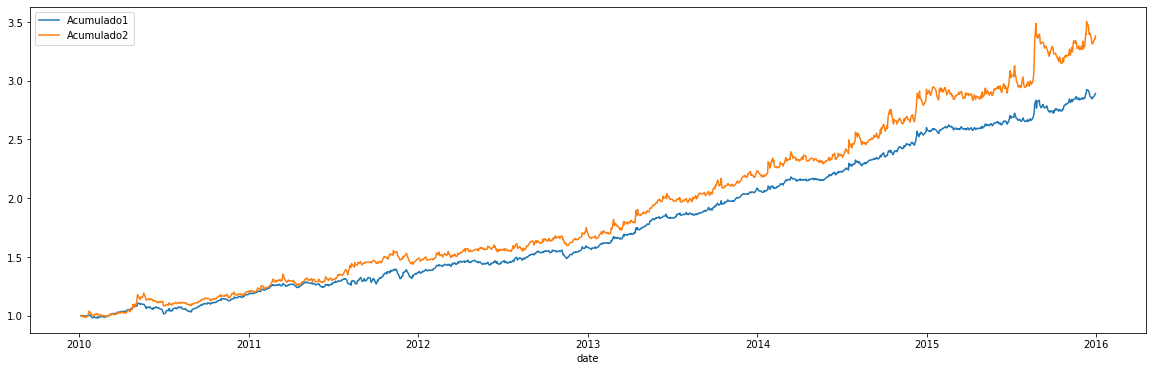

In [20]:
portfolio[["Acumulado1","Acumulado2"]].plot(figsize=(20,6))

In [21]:
lista=["SPY","^VIX"]
portfolio=pd.DataFrame()
i=np.arange(len(lista))
for i in i:
  try:
    a=Ticker(lista[i])
    df=a.history(start="2015-12-31",end="2020-12-31",interval='1d')
    df=df['adjclose']
    df=df.pct_change()
    df=df.droplevel("symbol")
    portfolio[lista[i]]=df
  except:
    pass

In [22]:
portfolio["Portfolio1"]=(1+0.886361*portfolio["SPY"])*(1+0.113639*portfolio["^VIX"])-1
portfolio["Portfolio2"]=(1+0.815083*portfolio["SPY"])*(1+0.184917*portfolio["^VIX"])-1
portfolio["Acumulado1"]=(1+portfolio["Portfolio1"]).cumprod()*100
portfolio["Acumulado2"]=(1+portfolio["Portfolio2"]).cumprod()*100
portfolio["Acumulado1"]=portfolio["Acumulado1"]/portfolio["Acumulado1"][1]
portfolio["Acumulado2"]=portfolio["Acumulado2"]/portfolio["Acumulado2"][1]

In [23]:
spy=dict()
spy["Annualized Return"]=annualize_rets(portfolio["SPY"],252)*100
spy["Annualized Vol"]=annualize_vol(portfolio["SPY"],252)*100
spy["Skewness"]=skewness(portfolio["SPY"])
spy["Kurtosis"]=kurtosis(portfolio["SPY"])
spy["Sharpe Ratio"]=sharpe_ratio(portfolio["SPY"],0,252)
spy["Max Drawdown"]=drawdown(portfolio["SPY"]).Drawdown.min()*100
spy["Calmar Ratio"]=abs(spy["Annualized Return"]/spy["Max Drawdown"])
spy["VaR"]=var_gaussian(portfolio["SPY"],level=1)
spy["ModifiedVar"]=var_gaussian(portfolio["SPY"],level=1,modified=True)
spy=pd.DataFrame.from_dict(spy.items())
spy=spy.set_index(0)
spy.index.name=None
spy.columns=["SPY"]

VIX=dict()
VIX["Annualized Return"]=annualize_rets(portfolio["^VIX"],252)*100
VIX["Annualized Vol"]=annualize_vol(portfolio["^VIX"],252)*100
VIX["Skewness"]=skewness(portfolio["^VIX"])
VIX["Kurtosis"]=kurtosis(portfolio["^VIX"])
VIX["Sharpe Ratio"]=sharpe_ratio(portfolio["^VIX"],0,252)
VIX["Max Drawdown"]=drawdown(portfolio["^VIX"]).Drawdown.min()*100
VIX["Calmar Ratio"]=abs(VIX["Annualized Return"]/VIX["Max Drawdown"])
VIX["VaR"]=var_gaussian(portfolio["^VIX"],level=1)
VIX["ModifiedVar"]=var_gaussian(portfolio["^VIX"],level=1,modified=True)
VIX=pd.DataFrame.from_dict(VIX.items())
VIX=VIX.set_index(0)
VIX.index.name=None
VIX.columns=["^VIX"]

Portfolio1=dict()
Portfolio1["Annualized Return"]=annualize_rets(portfolio["Portfolio1"],252)*100
Portfolio1["Annualized Vol"]=annualize_vol(portfolio["Portfolio1"],252)*100
Portfolio1["Skewness"]=skewness(portfolio["Portfolio1"])
Portfolio1["Kurtosis"]=kurtosis(portfolio["Portfolio1"])
Portfolio1["Sharpe Ratio"]=sharpe_ratio(portfolio["Portfolio1"],0,252)
Portfolio1["Max Drawdown"]=drawdown(portfolio["Portfolio1"]).Drawdown.min()*100
Portfolio1["Calmar Ratio"]=abs(Portfolio1["Annualized Return"]/Portfolio1["Max Drawdown"])
Portfolio1["VaR"]=var_gaussian(portfolio["Portfolio1"],level=1)
Portfolio1["ModifiedVar"]=var_gaussian(portfolio["Portfolio1"],level=1,modified=True)
Portfolio1=pd.DataFrame.from_dict(Portfolio1.items())
Portfolio1=Portfolio1.set_index(0)
Portfolio1.index.name=None
Portfolio1.columns=["Portfolio1"]

Portfolio2=dict()
Portfolio2["Annualized Return"]=annualize_rets(portfolio["Portfolio2"],252)*100
Portfolio2["Annualized Vol"]=annualize_vol(portfolio["Portfolio2"],252)*100
Portfolio2["Skewness"]=skewness(portfolio["Portfolio2"])
Portfolio2["Kurtosis"]=kurtosis(portfolio["Portfolio2"])
Portfolio2["Sharpe Ratio"]=sharpe_ratio(portfolio["Portfolio2"],0,252)
Portfolio2["Max Drawdown"]=drawdown(portfolio["Portfolio2"]).Drawdown.min()*100
Portfolio2["Calmar Ratio"]=abs(Portfolio2["Annualized Return"]/Portfolio2["Max Drawdown"])
Portfolio2["VaR"]=var_gaussian(portfolio["Portfolio2"],level=1)
Portfolio2["ModifiedVar"]=var_gaussian(portfolio["Portfolio2"],level=1,modified=True)
Portfolio2=pd.DataFrame.from_dict(Portfolio2.items())
Portfolio2=Portfolio2.set_index(0)
Portfolio2.index.name=None
Portfolio2.columns=["Portfolio2"]

resumo=pd.concat([spy,VIX,Portfolio1,Portfolio2],axis=1)

In [24]:
resumo

,SPY,^VIX,Portfolio1,Portfolio2
Annualized Return,14.993298,4.574559,24.623559,29.378217
Annualized Vol,18.871510,142.645032,12.888343,19.004897
Skewness,-0.773843,2.974331,1.776119,3.331182
Kurtosis,21.153992,28.710536,29.282498,40.530493
Sharpe Ratio,0.794494,0.032070,1.910530,1.545823
Max Drawdown,-33.717258,-75.123958,-17.481554,-12.602562
Calmar Ratio,0.444677,0.060893,1.408545,2.331130
VaR,0.027655,0.209041,0.018887,0.027851
ModifiedVar,0.082195,0.253467,0.048532,0.053573


No Período de 2016-2020, ainda que o Sharpe do Portfolio1 (alocação inversamente proporcional ao VaR) tenha sido superior ao Portfolio2 (alocação inversamente proporcional ao ModifiedVar), vemos um retorno anualizado com menor drawdown no Portfólio2, gerando grande diferença no Calmar Ratio (2,33 vs 1,40). Assim, a maior volatilidade do Portfólio2 se deve à assimetria positiva de retornos. O período de 2016-2020 teve dois eventos extremos, o "Volmageddon" em Fevereiro de 2018 (Veja que as curvam começam a se diferenciar a partir desse evento) e Março de 2020. Vemos que o uso do ModifiedVar foi efetivo, pois o portfólio ajustado por essa métrica reagiu melhor a períodos turbulentos. Assim, concluímos nossa análise, mostrando a importância de não se limitar à análise de volatilidade e premissas de normalidade como métricas de risco. Entender o conceito de assimetria e curtose é útil tanto para alocadores de fundos como para gestores, que devem adaptar seus portfólios e estratégias para enfrentar qualquer cenário.

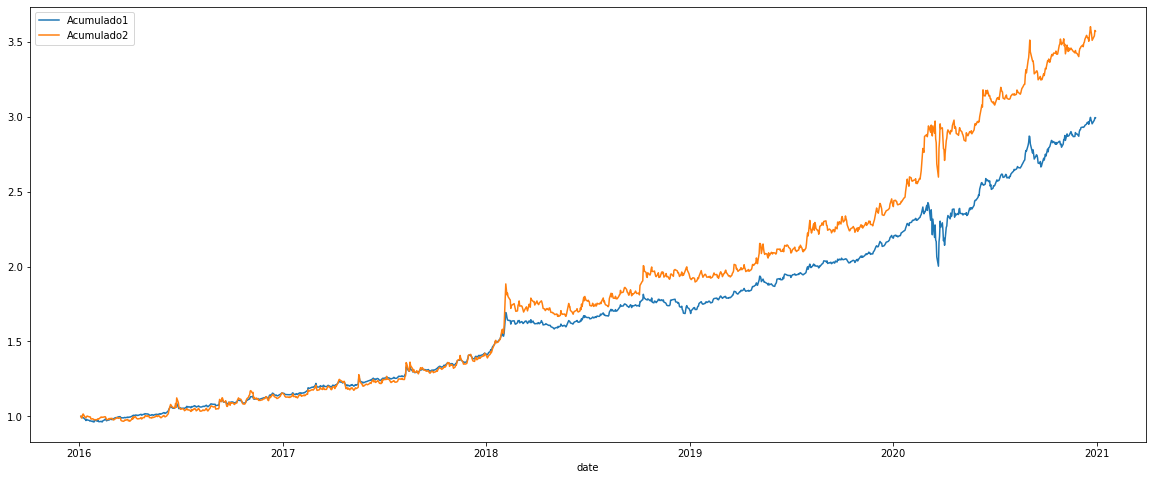

In [25]:
portfolio[["Acumulado1","Acumulado2"]].plot(figsize=(20,8))